<a href="https://colab.research.google.com/github/Ea0011/florence-exploration/blob/main/florence_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize and load model

In [12]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
model_id = 'microsoft/Florence-2-base'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    torch_dtype='auto'
  ).eval().to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
model

Florence2ForConditionalGeneration(
  (vision_tower): DaViT(
    (convs): ModuleList(
      (0): ConvEmbed(
        (proj): Conv2d(3, 128, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (1): ConvEmbed(
        (proj): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (2): ConvEmbed(
        (proj): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (3): ConvEmbed(
        (proj): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
    )
    (blocks): ModuleList(
      (0): MySequential(
        (0): MySequential(
          (spatial_block): SpatialBlock(
            (conv1): PreNorm(
              (fn): Depth

# Exploring Positional Encodings and Positional Prompts

In [4]:
processor.tokenizer("<loc_0>", add_special_tokens=False),  processor.tokenizer("<loc_999>", add_special_tokens=False) # location tokens range from 50269 to 51268

({'input_ids': [50269], 'attention_mask': [1]},
 {'input_ids': [51268], 'attention_mask': [1]})

In [7]:
token_embedding_enc = model.language_model.model.encoder.embed_tokens.weight.data
token_embedding_dec = model.language_model.model.decoder.embed_tokens.weight.data

location_token_embedding_enc = token_embedding_enc[50269:51269]
location_token_embedding_dec = token_embedding_dec[50269:51269]

In [63]:
img_pos_emb_col.unsqueeze(0).repeat(50, 1, 1).shape, img_pos_emb_row.unsqueeze(1).repeat(1, 50, 1).shape

(torch.Size([50, 50, 512]), torch.Size([50, 50, 512]))

In [71]:
# Get positional embeddings
img_pos_emb_row = model.image_pos_embed.row_embeddings.weight.data
img_pos_emb_col = model.image_pos_embed.column_embeddings.weight.data
img_feature_proj = model.image_projection.data
image_feature_norm = model.image_proj_norm

# Create map for 50x50 square image feature
img_pos_emb_cat = torch.cat([img_pos_emb_col.unsqueeze(0).repeat(50, 1, 1), img_pos_emb_row.unsqueeze(1).repeat(1, 50, 1)], dim=-1)
# Project to language model dimension

img_pos_emb_proj = img_pos_emb_cat @ img_feature_proj
image_pos_emb_norm = image_feature_norm(img_pos_emb_proj)


In [72]:
image_pos_emb_norm.shape

torch.Size([50, 50, 768])

In [9]:
loc_emb_similarity = location_token_embedding_enc @ location_token_embedding_dec.T # Definitely not shared

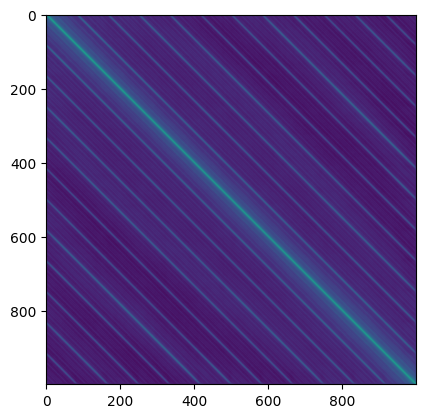

In [13]:
plt.imshow(loc_emb_similarity) # shows periodic similarity patterns

In [16]:
loc_emb_similarity.argmax(dim=1) - torch.arange(1000)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Do Location Embeddings in the Embedding Table interract with learned 2D positional embeddings


---


Compute the composition score: ||AB||_F / (||A||_F * ||B||_F) to get an idea

The location tokens do not significantly interract with the positional embeddings in the encoder.  

The decoder positional embedding and location tokens do interract with each other.  

In [130]:
# How do location tokens align with positional embeddings in the model?
img_pos = image_pos_emb_norm[11, :5].reshape(-1, 768)
(img_pos @ location_token_embedding_enc.T).norm(p="fro") / (img_pos.norm(p="fro") * location_token_embedding_enc.norm(p="fro"))

tensor(0.0357, dtype=torch.float16, grad_fn=<DivBackward0>)

In [116]:
(img_pos @ location_token_embedding_dec.T).norm(p="fro") / (img_pos.norm(p="fro") * location_token_embedding_dec.norm(p="fro"))

tensor(0.0375, dtype=torch.float16, grad_fn=<DivBackward0>)

In [117]:
(img_pos @ location_token_embedding_dec.T).norm(p="fro") / (img_pos.norm(p="fro") * location_token_embedding_dec.norm(p="fro"))

tensor(0.0375, dtype=torch.float16, grad_fn=<DivBackward0>)

In [118]:
(img_pos @ location_token_embedding_enc.T).norm(p="fro") / (img_pos.norm(p="fro") * location_token_embedding_enc.norm(p="fro"))

tensor(0.0375, dtype=torch.float16, grad_fn=<DivBackward0>)

In [87]:
# Composition score for random matrices of the same size
scores = []

for i in range(100):
  A = torch.randn_like(img_pos) * (0.0002) ** 0.5
  B = torch.randn_like(location_token_embedding_enc) * (0.0002) ** 0.5
  scores.append((A @ B.T).norm(p="fro") / (A.norm(p="fro") * B.norm(p="fro")))

(array([ 2.,  2.,  2., 11., 17., 20., 25., 10.,  7.,  4.]),
 array([0.03494263, 0.03515625, 0.03533936, 0.03555298, 0.03573608,
        0.03594971, 0.03616333, 0.03634644, 0.03656006, 0.03674316,
        0.03695679]),
 <BarContainer object of 10 artists>)

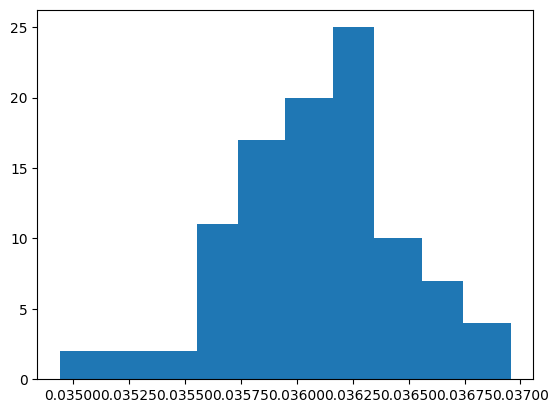

In [88]:
plt.hist(scores)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

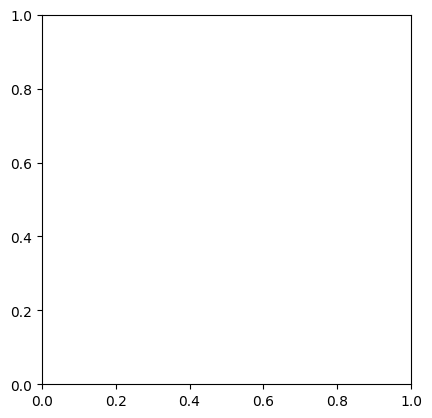

In [131]:
plt.imshow(img_pos @ location_token_embedding_dec.T)

In [143]:
loc_token_img_sim = (image_pos_emb_norm @ location_token_embedding_enc.T)

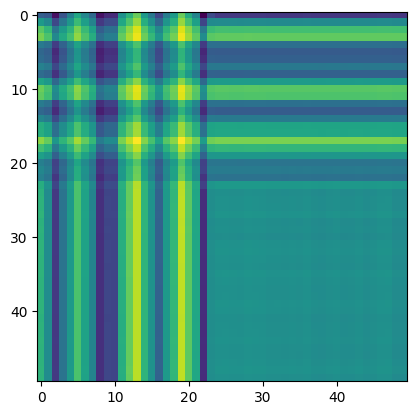

In [150]:
plt.imshow(loc_token_img_sim[:, :, 800].detach().cpu().numpy())

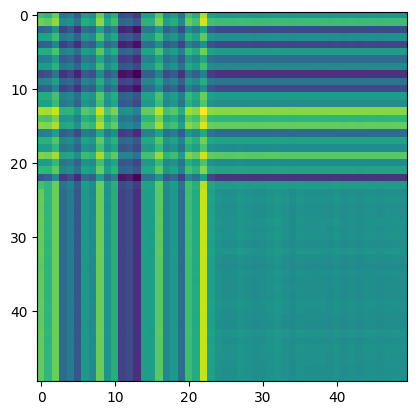

In [146]:
plt.imshow(loc_token_img_sim[:, :, -1].detach().cpu().numpy())